# setting up the training data

59
This choice will generate autonomous dynamics
No change  applied to TS or repr data


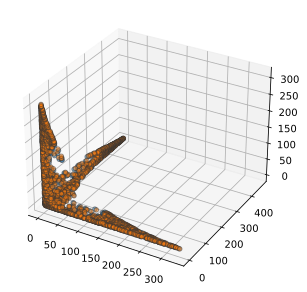

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
import numpy as np
from models.training import create_dataloader, maskedTrainer


# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 

torch.backends.cudnn.deterministic = True
seed = np.random.randint(1,200)
seed = 59
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
print(seed)
g = torch.Generator()
g.manual_seed(seed)

# design choices 
chosen_problem = 'repressilator'
data_noise = 0.
n_different_weights = 1
if n_different_weights == 1:
    print('This choice will generate autonomous dynamics')
else:
    print('This choice generates non-autonomous dynamics, letting the weights depend on time')

possible_problem = {'moons':'moons', 'ToggleSwitch':'TS', 'repressilator':'repr', 'restricted_TS': 'restrictedTS'} 
# this choices determine the data set that we build and subsequent choices on the construction of the neural ODE 
# - in particular, it determines the dimensions 
problem = possible_problem[chosen_problem]

plotlim = [0, 5]

dataloader, dataloader_viz = create_dataloader(problem, batch_size = 2000, noise = data_noise, 
                                               plotlim = plotlim, random_state = seed, label = 'vector')

# setting up the nODE architecture

In [2]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 1, n_different_weights
bound = 0.
fp = False
cross_entropy = False
turnpike = False

# choice of model: what nonlinearity is used and if the nonlinearity is applied before (inside) or after (outside) the linear weights
# another choice is bottleneck, but I don't understand it
# non_linearity = 'tanh' # OR 'relu' 'sigmoid' 'leakyrelu' 'tanh_prime'
# architecture = 'inside' 'outside'
non_linearity = 'tanh'
architecture = 'inside' # architecture grn doesn seem to work as expected
architectures = {'inside': -1, 'outside': 0, 'bottleneck': 1, 'restricted': 2, 'grn': 3}
# number of optimization runs in which the dataset is used for gradient decent
num_epochs = 50
if problem == 'moons' or problem == 'TS' or problem == "restrictedTS":
    hidden_dim, data_dim = 2, 2 
else:
    hidden_dim, data_dim = 3, 3 
augment_dim = 0

# resets the seed - allows for coherent runs in the gradient descent as well
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
node = NeuralODE(device, data_dim, hidden_dim, output_dim=data_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_node = torch.optim.Adam(node.parameters(), lr=1e-1) 

# training phase with mask

In [3]:
# explicit mask for the repressilator
mask = torch.Tensor([[0,0.,1.0],[1.0,0,0.],[0,1.0,0]]) 

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
trainer = maskedTrainer(node, optimizer_node, device, mask, cross_entropy=cross_entropy,
                         bound=bound, verbose = True) 

In [4]:
trainer.train(dataloader, 50)


Iteration 0/25
Loss: 62.210
Masked loss: 1.743

Iteration 10/25
Loss: 56.312
Masked loss: 3.988

Iteration 20/25
Loss: 50.348
Masked loss: 3.574
Epoch 1: 51.874

Iteration 0/25
Loss: 47.337
Masked loss: 3.246

Iteration 10/25
Loss: 44.134
Masked loss: 2.439

Iteration 20/25
Loss: 44.207
Masked loss: 1.368
Epoch 2: 48.059

Iteration 0/25
Loss: 43.407
Masked loss: 0.900

Iteration 10/25
Loss: 42.558
Masked loss: 0.252

Iteration 20/25
Loss: 46.641
Masked loss: 0.081
Epoch 3: 46.535

Iteration 0/25
Loss: 38.937
Masked loss: 0.144

Iteration 10/25
Loss: 49.915
Masked loss: 0.067

Iteration 20/25
Loss: 49.150
Masked loss: 0.117
Epoch 4: 46.208

Iteration 0/25
Loss: 47.827
Masked loss: 0.206

Iteration 10/25
Loss: 39.291
Masked loss: 0.097

Iteration 20/25
Loss: 42.912
Masked loss: 0.057
Epoch 5: 46.086

Iteration 0/25
Loss: 43.624
Masked loss: 0.124

Iteration 10/25
Loss: 39.122
Masked loss: 0.079

Iteration 20/25
Loss: 48.438
Masked loss: 0.151
Epoch 6: 46.027

Iteration 0/25
Loss: 39.364

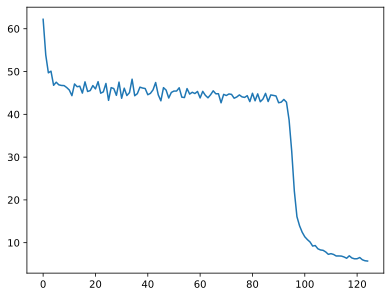

In [5]:
plt.plot(trainer.histories['loss_history'])

In [6]:
trainer.model.flow.dynamics.fc2_time[0].weight 

Parameter containing:
tensor([[ 9.9914e-02,  2.9208e-02, -1.4714e+01],
        [-1.9904e+01,  5.6980e-03, -1.9127e-02],
        [-7.6875e-02, -1.2922e+01,  2.7741e-01]], requires_grad=True)

In [7]:
trainer.model.flow.dynamics.fc2_time[0].bias

Parameter containing:
tensor([13.1338, 18.2652, 11.1707], requires_grad=True)

In [8]:
mask

tensor([[0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.]])

In [9]:
(trainer.model.flow.dynamics.fc2_time[0].weight * (1 - trainer.mask)).norm(1)

tensor(0.5082, grad_fn=<LinalgVectorNormBackward0>)

In [10]:
node.forward(torch.Tensor([1.,2.,3.]))[0].detach()

tensor([-0.0480, 13.6649,  1.4350])

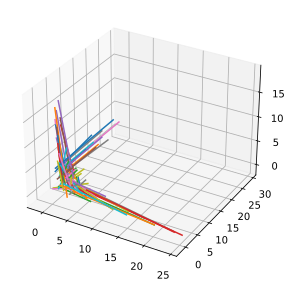

In [11]:
from torch.distributions.uniform import Uniform

low, high = plotlim  # range of uniform distribution
size = 70
shape = size, 3
X = np.array(Uniform(low, high).sample(shape) )
ax = plt.figure().add_subplot(projection='3d')

for x0 in X:
    x1 = node.forward(torch.Tensor(x0))[0].detach()
    x = np.array([x0[0], x1[0]])
    y = np.array([x0[1], x1[1]])
    z = np.array([x0[2], x1[2]])
    ax.plot(x, y, z)

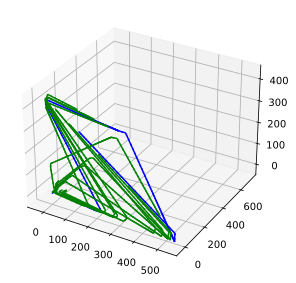

In [12]:
ax = plt.figure().add_subplot(projection='3d')
start = torch.Tensor([1,2,3.])
for i in range(200):
    traj = node.flow.trajectory(start, 10)
    ax.plot(traj.detach().numpy()[:,0],traj.detach().numpy()[:,1],traj.detach().numpy()[:,2],color='b')
    start = traj[-1,:]
for j in range(10):
    shape = 1,3
    start = Uniform(0,60).sample(shape)[0]
    for i in range(80):
        traj = node.flow.trajectory(start, 10)
        ax.plot(traj.detach().numpy()[:,0],traj.detach().numpy()[:,1],traj.detach().numpy()[:,2],color='g')
        start = traj[-1,:]

# original system

In [13]:
def repressilator(xyz, t):
    x, y, z = xyz[0], xyz[1], xyz[2]
    n = 5
    gamma, lx, ly, lz, deltax, deltay, deltaz, thetax, thetay, thetaz = 0.05, 0.01, 0.02, 0.03, 30.1, 30.2, 20.7, 1, 1.1, 1.2
    x_dot = - gamma * x + lx + deltax * thetax ** n / (thetax ** n + z ** n)
    y_dot = - gamma * y + ly + deltay * thetay ** n / (thetay ** n + x ** n)
    z_dot = - gamma * z + lz + deltaz * thetaz ** n / (thetaz ** n + y ** n)
    return np.array([x_dot, y_dot, z_dot])

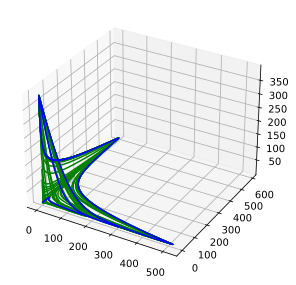

In [14]:
import scipy


iters = 20
size = [iters, 3]  # dimension of the pytorch tensor to be generated
low, high = plotlim  # range of uniform distribution

X = np.array(torch.distributions.uniform.Uniform(low, high).sample(size))

deltat = .5
Y = np.array([scipy.integrate.odeint(repressilator,
                            X[i, :], np.linspace(0,80*4,100))
                            for i in range(iters)])

ax = plt.figure().add_subplot(projection='3d')
for i in range(iters):
    ax.plot(Y[i,:,0],Y[i,:,1],Y[i,:,2],color='g')

Y = scipy.integrate.odeint(repressilator,
                            np.array([1,2,3.]), np.linspace(0,200*4,300))
                            
ax.plot(Y[:,0],Y[:,1],Y[:,2],color='b')

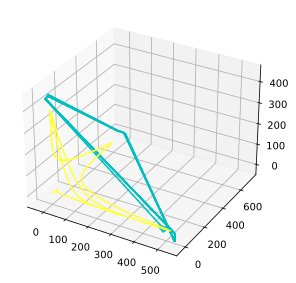

In [22]:
from matplotlib import cm

ax = plt.figure().add_subplot(projection='3d')
start = torch.Tensor([500,20,3.])
for i in range(1200):
    traj = node.flow.trajectory(start, 20)
    ax.plot(traj.detach().numpy()[:,0],traj.detach().numpy()[:,1],traj.detach().numpy()[:,2],color='c')
    start = traj[-1,:]
Y = scipy.integrate.odeint(repressilator,
                            np.array([1,2,3.]), np.linspace(0,200*4,300))
                            
ax.plot(Y[:,0],Y[:,1],Y[:,2],c=cm.hot(np.abs(0.8*(len(Y[:,1]))/len(Y[:,1]))))
#azm=ax.azim

#ax.view_init(elev=20, azim=-1.25*azm)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

plot_3d_orbit(Y[:,0],Y[:,1],Y[:,2],range(len(Y[:,1])), ax, plt.get_cmap('winter'))

ax.set_xlim(Y[:,0].min(), Y[:,0].max())
ax.set_ylim(Y[:,1].min(), Y[:,1].max())
ax.set_zlim(Y[:,2].min(), Y[:,2].max())
plt.show()
#plt.plot(Y[:,0],Y[:,1],c=cm.hot(np.linspace(0,0.8,Y.shape[0])))

In [ ]:
Y.shape[0]

In [ ]:
from matplotlib import cm

x = np.linspace(0, 5*np.pi, 300)
y = np.sin(2*x)
plt.scatter(x,y, c=cm.hot(np.linspace(0,0.8,x.shape[0])), edgecolor='none')

In [ ]:
np.abs(0.8*x/np.max(x))

In [ ]:
np.abs(0.8*np.array(range(Y.shape[0]))/Y.shape[0])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

def get_segments(x, y, z):
    """Convert lists of coordinates to a list of segments to be used
    with Matplotlib's Line3DCollection.
    """
    points = np.ma.array((x, y, z)).T.reshape(-1, 1, 3)
    return np.ma.concatenate([points[:-1], points[1:]], axis=1)


def plot_3d_orbit(x,y,z,T, ax, cmap=plt.get_cmap("bwr")):
    segments = get_segments(x, y, z)
    c = Line3DCollection(segments, cmap=cmap, array=T)
    ax.add_collection(c)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
n = 100
cmap = plt.get_cmap("bwr")
theta = np.linspace(-4 * np.pi, 4 * np.pi, n)
z = np.linspace(-2, 2, n)
r = z**2 + 1
x = r * np.sin(theta)
y = r * np.cos(theta)
T = np.linspace(0,0.8,n)

plot_3d_orbit(x,y,z,T, ax, plt.get_cmap('Blues'))
plot_3d_orbit(x,y,z+3,T, ax, plt.get_cmap('Greens'))

ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
ax.set_zlim(z.min(), z.max()+3)
plt.show()

In [19]:
node.flow.dynamics.fc2_time[0].weight

Parameter containing:
tensor([[ 9.9914e-02,  2.9208e-02, -1.4714e+01],
        [-1.9904e+01,  5.6980e-03, -1.9127e-02],
        [-7.6875e-02, -1.2922e+01,  2.7741e-01]], requires_grad=True)

In [20]:
mask

tensor([[0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.]])